## Set up
Import all required libraries

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import cv2
import gc
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split, KFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (f1_score, roc_auc_score, precision_score, recall_score,
                             accuracy_score, confusion_matrix, classification_report,
                             roc_curve, precision_recall_curve, average_precision_score)

In [2]:
# Set random seeds
random.seed(42)
torch.manual_seed(42)
np.random.seed(42)

## Data
Load and preprocess data

In [3]:
# Set image and metadata paths
img_dir = "/kaggle/input/covid-audio-data/augmented_melspectograms/melspectograms/"
label_df = pd.read_csv("/kaggle/input/covid-audio-data/labels.csv")

train_df, test_df = train_test_split(label_df, 
                                     test_size=0.2, 
                                     stratify=label_df["label"], 
                                     random_state=42)
train_df, val_df = train_test_split(train_df, 
                                    test_size=0.1, 
                                    stratify=train_df["label"], 
                                    random_state=42)

# PyTorch Dataset for loading melspectrogram images and their corresponding labels
class MelSpectrogramDataset(Dataset):
    def __init__(self, df, img_dir):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        label = self.df.iloc[idx]["label"]
        filename = self.df.iloc[idx]["filename"]

        # Read image
        img_path = os.path.join(self.img_dir, filename)
        img = cv2.imread(img_path)
        img = img.astype(np.float32) / 255.0
        img = img.transpose(2, 0, 1)  # Convert (H, W, C) to (C, H, W)

        return torch.tensor(img, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [4]:
# Set up data loaders
BATCH_SIZE = 128

train_dataset = MelSpectrogramDataset(train_df, img_dir)
val_dataset = MelSpectrogramDataset(val_df, img_dir)
test_dataset = MelSpectrogramDataset(test_df, img_dir)

train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True, 
                          num_workers=2, 
                          pin_memory=True)
test_loader = DataLoader(test_dataset, 
                         batch_size=BATCH_SIZE, 
                         shuffle=False, 
                         num_workers=2, 
                         pin_memory=True)
val_loader = DataLoader(val_dataset, 
                        batch_size=BATCH_SIZE, 
                        shuffle=False, 
                        num_workers=2, 
                        pin_memory=True)

# Clear unused memory
gc.collect()
torch.cuda.empty_cache()

## Model
Build and train model

In [5]:
class ConvNet(nn.Module):
    def __init__(self, input_dim,hidden_size_1=16,hidden_size_2=32, hidden_size_3=64, hidden_size_4=128):
        super(ConvNet, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(input_dim[0], hidden_size_1, kernel_size=2, stride=1, padding=1), # Convolutional layer
            nn.BatchNorm2d(hidden_size_1),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3))
        self.layer2 = nn.Sequential(
            nn.Conv2d(hidden_size_1, hidden_size_2, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(hidden_size_2),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3))
        self.layer3 = nn.Sequential(
            nn.Conv2d(hidden_size_2, hidden_size_3, kernel_size=2, stride=1, padding=1),
            nn.BatchNorm2d(hidden_size_3),
            nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Dropout(0.3))

        with torch.no_grad():
            dummy_input = torch.zeros(1, *input_dim)
            out = self.layer1(dummy_input)
            out = self.layer2(out)
            out = self.layer3(out)
            flatten_dim = out.view(1, -1).shape[1]

        self.fc = nn.Linear(flatten_dim, 1)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        features = out.clone()
        out = out.reshape(out.size(0), -1) # Flatten everything except the batch
        out = self.fc(out)
        return out, features 

In [6]:
# Run on GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Get one image to determine input dimensions
sample_img, _ = train_dataset[0]  # First image and label
input_dim = sample_img.shape  # (C, H, W)
print("Input shape:", input_dim)

cuda
Input shape: torch.Size([3, 199, 515])


In [7]:
# Initialize model
cnn = ConvNet(input_dim=input_dim)

if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs")
    cnn = nn.DataParallel(cnn)
cnn.to(device)

ConvNet(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Dropout(p=0.3, inplace=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Dropout(p=0.3, inplace=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (4): Dropout(p=0.3, inplace=False)
  )
  (fc): Linear(in_features=104000, out_features=1, bias=True)
)

In [8]:
# Hyperparameters
learning_rate_cnn = 0.001
EPOCHS = 10

# Loss, optimizer
criterion_cnn = nn.BCEWithLogitsLoss()
optimizer_cnn = torch.optim.Adam(cnn.parameters(), lr=learning_rate_cnn)

In [9]:
# Metrics to keep track of, early stopping parameters
train_accuracies = []
val_accuracies = []
train_loss=[]
val_loss=[]
best_auc = 0.0
epochs_no_improve = 0
EPOCHS = 200
patience = 10
early_stop = False

cnn.train()

for e in tqdm(range(1, EPOCHS+1)):
    running_loss = 0.0
    correct = 0
    total = 0

    # Training
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).view(-1)

        optimizer_cnn.zero_grad() # Reset gradients

        y_pred_logits, _ = cnn(X_batch)
        y_pred_logits = y_pred_logits.view(-1) # Forward pass
        y_pred_proba = torch.sigmoid(y_pred_logits) # Convert logits to probabilities
        label_predicted = (y_pred_proba >= 0.5).int() # Binary prediction

        loss = criterion_cnn(y_pred_logits, y_batch.float()) # Compute loss
        running_loss += loss.item()

        total += y_batch.size(0)
        correct += (label_predicted == y_batch.int()).sum().item() # Count correct predictions

        loss.backward() # Backpropagation
        optimizer_cnn.step() # Update weights

    train_acc = correct / total
    train_accuracies.append(train_acc)
    train_loss.append(running_loss/len(train_loader))

    # Validation
    cnn.eval()  # Eval mode - no dropout or gradients
    val_correct = 0
    val_total = 0
    val_running_loss = 0.0
    all_val_probs = []
    all_val_labels = []
    
    with torch.no_grad(): # No gradient calculation
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device).view(-1)

            y_pred_logits, _ = cnn(X_batch)
            y_pred_logits = y_pred_logits.view(-1) # Forward pass
            y_pred_proba = torch.sigmoid(y_pred_logits) # Convert logits to probabilities
            val_predicted = (y_pred_proba >= 0.5).int() # Binary prediction

            # For AUC calculations
            all_val_probs.extend(y_pred_proba.cpu().numpy())
            all_val_labels.extend(y_batch.cpu().numpy())

            loss = criterion_cnn(y_pred_logits, y_batch.float()) # Compute loss
            val_running_loss += loss.item()

            val_total += y_batch.size(0)
            val_correct += (val_predicted == y_batch.int()).sum().item() # Count correct predictions

    # Calulate AUC for model saving
    val_auc = roc_auc_score(all_val_labels, all_val_probs)
    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)
    val_loss.append(val_running_loss/len(val_loader))

    # Early stopping and save model with best AUC
    if val_auc > best_auc:
        best_auc = val_auc
        torch.save(cnn.state_dict(), '/kaggle/working/best_cnn.pth')
        print(f"Best model saved at epoch {e} with AUC = {best_auc:.4f}")
        epochs_no_improve = 0
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered at epoch {e}")
            early_stop = True

    if early_stop:
        break

    cnn.train() # Back to train mode

    # Print metrics for current model
    print(f'Epoch {e+0:03}: | Loss: {running_loss/len(train_loader):.5f} | Acc: {train_acc:.3f} | Validation Accuracy: {val_acc:.3f}')

  0%|          | 1/200 [02:23<7:55:40, 143.42s/it]

Best model saved at epoch 1 with AUC = 0.6935
Epoch 001: | Loss: 1.25700 | Acc: 0.561 | Validation Accuracy: 0.524


  1%|          | 2/200 [03:46<5:55:28, 107.72s/it]

Best model saved at epoch 2 with AUC = 0.7368
Epoch 002: | Loss: 0.66656 | Acc: 0.621 | Validation Accuracy: 0.656


  2%|▏         | 3/200 [05:07<5:14:42, 95.85s/it] 

Best model saved at epoch 3 with AUC = 0.7498
Epoch 003: | Loss: 0.62940 | Acc: 0.648 | Validation Accuracy: 0.681


  2%|▏         | 4/200 [06:28<4:53:12, 89.76s/it]

Epoch 004: | Loss: 0.58188 | Acc: 0.686 | Validation Accuracy: 0.532


  2%|▎         | 5/200 [07:51<4:43:37, 87.27s/it]

Best model saved at epoch 5 with AUC = 0.7657
Epoch 005: | Loss: 0.57814 | Acc: 0.693 | Validation Accuracy: 0.719


  3%|▎         | 6/200 [09:08<4:30:58, 83.81s/it]

Best model saved at epoch 6 with AUC = 0.7705
Epoch 006: | Loss: 0.55530 | Acc: 0.704 | Validation Accuracy: 0.726


  4%|▎         | 7/200 [10:29<4:27:21, 83.11s/it]

Best model saved at epoch 7 with AUC = 0.7766
Epoch 007: | Loss: 0.54834 | Acc: 0.710 | Validation Accuracy: 0.700


  4%|▍         | 8/200 [11:50<4:23:34, 82.37s/it]

Best model saved at epoch 8 with AUC = 0.7919
Epoch 008: | Loss: 0.53582 | Acc: 0.716 | Validation Accuracy: 0.730


  4%|▍         | 9/200 [13:11<4:20:49, 81.93s/it]

Best model saved at epoch 9 with AUC = 0.7938
Epoch 009: | Loss: 0.52400 | Acc: 0.729 | Validation Accuracy: 0.728


  5%|▌         | 10/200 [14:32<4:18:50, 81.74s/it]

Best model saved at epoch 10 with AUC = 0.7949
Epoch 010: | Loss: 0.52199 | Acc: 0.728 | Validation Accuracy: 0.697


  6%|▌         | 11/200 [15:50<4:13:28, 80.47s/it]

Best model saved at epoch 11 with AUC = 0.8067
Epoch 011: | Loss: 0.50277 | Acc: 0.739 | Validation Accuracy: 0.625


  6%|▌         | 12/200 [17:11<4:12:06, 80.46s/it]

Best model saved at epoch 12 with AUC = 0.8133
Epoch 012: | Loss: 0.48711 | Acc: 0.749 | Validation Accuracy: 0.709


  6%|▋         | 13/200 [18:35<4:14:27, 81.65s/it]

Best model saved at epoch 13 with AUC = 0.8194
Epoch 013: | Loss: 0.49269 | Acc: 0.748 | Validation Accuracy: 0.747


  7%|▋         | 14/200 [19:55<4:11:29, 81.12s/it]

Best model saved at epoch 14 with AUC = 0.8225
Epoch 014: | Loss: 0.47642 | Acc: 0.759 | Validation Accuracy: 0.633


  8%|▊         | 15/200 [21:15<4:09:21, 80.87s/it]

Epoch 015: | Loss: 0.47028 | Acc: 0.763 | Validation Accuracy: 0.733


  8%|▊         | 16/200 [22:36<4:07:46, 80.80s/it]

Best model saved at epoch 16 with AUC = 0.8289
Epoch 016: | Loss: 0.46452 | Acc: 0.766 | Validation Accuracy: 0.743


  8%|▊         | 17/200 [23:56<4:05:36, 80.53s/it]

Epoch 017: | Loss: 0.45304 | Acc: 0.776 | Validation Accuracy: 0.762


  9%|▉         | 18/200 [25:17<4:04:41, 80.67s/it]

Best model saved at epoch 18 with AUC = 0.8344
Epoch 018: | Loss: 0.44920 | Acc: 0.780 | Validation Accuracy: 0.746


 10%|▉         | 19/200 [26:38<4:03:48, 80.82s/it]

Epoch 019: | Loss: 0.45850 | Acc: 0.772 | Validation Accuracy: 0.755


 10%|█         | 20/200 [28:02<4:05:25, 81.81s/it]

Best model saved at epoch 20 with AUC = 0.8403
Epoch 020: | Loss: 0.43443 | Acc: 0.787 | Validation Accuracy: 0.712


 10%|█         | 21/200 [29:25<4:05:06, 82.16s/it]

Best model saved at epoch 21 with AUC = 0.8464
Epoch 021: | Loss: 0.43218 | Acc: 0.787 | Validation Accuracy: 0.765


 11%|█         | 22/200 [30:54<4:10:02, 84.29s/it]

Best model saved at epoch 22 with AUC = 0.8534
Epoch 022: | Loss: 0.41957 | Acc: 0.796 | Validation Accuracy: 0.758


 12%|█▏        | 23/200 [32:25<4:14:24, 86.24s/it]

Epoch 023: | Loss: 0.41528 | Acc: 0.799 | Validation Accuracy: 0.699


 12%|█▏        | 24/200 [33:50<4:11:37, 85.78s/it]

Best model saved at epoch 24 with AUC = 0.8624
Epoch 024: | Loss: 0.41624 | Acc: 0.800 | Validation Accuracy: 0.759


 12%|█▎        | 25/200 [35:14<4:09:20, 85.49s/it]

Best model saved at epoch 25 with AUC = 0.8630
Epoch 025: | Loss: 0.39860 | Acc: 0.809 | Validation Accuracy: 0.759


 13%|█▎        | 26/200 [36:39<4:07:08, 85.22s/it]

Epoch 026: | Loss: 0.39119 | Acc: 0.812 | Validation Accuracy: 0.685


 14%|█▎        | 27/200 [38:03<4:04:34, 84.82s/it]

Best model saved at epoch 27 with AUC = 0.8666
Epoch 027: | Loss: 0.38241 | Acc: 0.820 | Validation Accuracy: 0.772


 14%|█▍        | 28/200 [39:27<4:02:16, 84.52s/it]

Best model saved at epoch 28 with AUC = 0.8739
Epoch 028: | Loss: 0.37831 | Acc: 0.822 | Validation Accuracy: 0.773


 14%|█▍        | 29/200 [40:52<4:01:27, 84.72s/it]

Epoch 029: | Loss: 0.37699 | Acc: 0.824 | Validation Accuracy: 0.785


 15%|█▌        | 30/200 [42:14<3:57:38, 83.87s/it]

Best model saved at epoch 30 with AUC = 0.8780
Epoch 030: | Loss: 0.36421 | Acc: 0.830 | Validation Accuracy: 0.774


 16%|█▌        | 31/200 [43:36<3:54:40, 83.32s/it]

Best model saved at epoch 31 with AUC = 0.8869
Epoch 031: | Loss: 0.35923 | Acc: 0.834 | Validation Accuracy: 0.780


 16%|█▌        | 32/200 [44:56<3:50:17, 82.25s/it]

Best model saved at epoch 32 with AUC = 0.8974
Epoch 032: | Loss: 0.34854 | Acc: 0.837 | Validation Accuracy: 0.809


 16%|█▋        | 33/200 [46:15<3:46:22, 81.33s/it]

Epoch 033: | Loss: 0.33595 | Acc: 0.847 | Validation Accuracy: 0.800


 17%|█▋        | 34/200 [47:36<3:45:04, 81.35s/it]

Best model saved at epoch 34 with AUC = 0.8987
Epoch 034: | Loss: 0.32848 | Acc: 0.851 | Validation Accuracy: 0.799


 18%|█▊        | 35/200 [48:58<3:43:48, 81.39s/it]

Best model saved at epoch 35 with AUC = 0.9039
Epoch 035: | Loss: 0.32540 | Acc: 0.852 | Validation Accuracy: 0.781


 18%|█▊        | 36/200 [50:15<3:39:13, 80.20s/it]

Best model saved at epoch 36 with AUC = 0.9069
Epoch 036: | Loss: 0.33028 | Acc: 0.849 | Validation Accuracy: 0.810


 18%|█▊        | 37/200 [51:35<3:37:24, 80.03s/it]

Best model saved at epoch 37 with AUC = 0.9127
Epoch 037: | Loss: 0.31364 | Acc: 0.857 | Validation Accuracy: 0.812


 19%|█▉        | 38/200 [52:58<3:39:06, 81.15s/it]

Best model saved at epoch 38 with AUC = 0.9158
Epoch 038: | Loss: 0.30555 | Acc: 0.862 | Validation Accuracy: 0.822


 20%|█▉        | 39/200 [54:17<3:35:54, 80.46s/it]

Best model saved at epoch 39 with AUC = 0.9183
Epoch 039: | Loss: 0.29733 | Acc: 0.865 | Validation Accuracy: 0.824


 20%|██        | 40/200 [55:39<3:35:14, 80.72s/it]

Best model saved at epoch 40 with AUC = 0.9239
Epoch 040: | Loss: 0.29742 | Acc: 0.868 | Validation Accuracy: 0.815


 20%|██        | 41/200 [57:06<3:39:14, 82.73s/it]

Best model saved at epoch 41 with AUC = 0.9242
Epoch 041: | Loss: 0.28616 | Acc: 0.872 | Validation Accuracy: 0.821


 21%|██        | 42/200 [58:31<3:39:12, 83.24s/it]

Best model saved at epoch 42 with AUC = 0.9276
Epoch 042: | Loss: 0.27211 | Acc: 0.882 | Validation Accuracy: 0.834


 22%|██▏       | 43/200 [59:56<3:39:29, 83.88s/it]

Best model saved at epoch 43 with AUC = 0.9296
Epoch 043: | Loss: 0.26980 | Acc: 0.880 | Validation Accuracy: 0.847


 22%|██▏       | 44/200 [1:01:16<3:35:22, 82.84s/it]

Best model saved at epoch 44 with AUC = 0.9331
Epoch 044: | Loss: 0.27056 | Acc: 0.881 | Validation Accuracy: 0.845


 22%|██▎       | 45/200 [1:02:38<3:32:54, 82.42s/it]

Epoch 045: | Loss: 0.26107 | Acc: 0.886 | Validation Accuracy: 0.846


 23%|██▎       | 46/200 [1:04:02<3:32:47, 82.90s/it]

Best model saved at epoch 46 with AUC = 0.9350
Epoch 046: | Loss: 0.25788 | Acc: 0.889 | Validation Accuracy: 0.843


 24%|██▎       | 47/200 [1:05:25<3:31:20, 82.88s/it]

Epoch 047: | Loss: 0.25772 | Acc: 0.888 | Validation Accuracy: 0.853


 24%|██▍       | 48/200 [1:06:46<3:29:12, 82.58s/it]

Best model saved at epoch 48 with AUC = 0.9423
Epoch 048: | Loss: 0.24719 | Acc: 0.895 | Validation Accuracy: 0.861


 24%|██▍       | 49/200 [1:08:08<3:26:48, 82.17s/it]

Best model saved at epoch 49 with AUC = 0.9428
Epoch 049: | Loss: 0.24549 | Acc: 0.895 | Validation Accuracy: 0.861


 25%|██▌       | 50/200 [1:09:30<3:25:45, 82.30s/it]

Best model saved at epoch 50 with AUC = 0.9432
Epoch 050: | Loss: 0.24071 | Acc: 0.897 | Validation Accuracy: 0.867


 26%|██▌       | 51/200 [1:10:51<3:23:26, 81.92s/it]

Best model saved at epoch 51 with AUC = 0.9457
Epoch 051: | Loss: 0.23862 | Acc: 0.898 | Validation Accuracy: 0.872


 26%|██▌       | 52/200 [1:12:10<3:19:21, 80.82s/it]

Epoch 052: | Loss: 0.23010 | Acc: 0.901 | Validation Accuracy: 0.866


 26%|██▋       | 53/200 [1:13:31<3:18:37, 81.07s/it]

Best model saved at epoch 53 with AUC = 0.9487
Epoch 053: | Loss: 0.22675 | Acc: 0.903 | Validation Accuracy: 0.873


 27%|██▋       | 54/200 [1:14:52<3:16:47, 80.87s/it]

Epoch 054: | Loss: 0.21646 | Acc: 0.907 | Validation Accuracy: 0.876


 28%|██▊       | 55/200 [1:16:09<3:13:00, 79.87s/it]

Best model saved at epoch 55 with AUC = 0.9517
Epoch 055: | Loss: 0.22085 | Acc: 0.905 | Validation Accuracy: 0.882


 28%|██▊       | 56/200 [1:17:28<3:11:08, 79.64s/it]

Epoch 056: | Loss: 0.21505 | Acc: 0.909 | Validation Accuracy: 0.855


 28%|██▊       | 57/200 [1:18:46<3:08:40, 79.17s/it]

Best model saved at epoch 57 with AUC = 0.9533
Epoch 057: | Loss: 0.21182 | Acc: 0.912 | Validation Accuracy: 0.885


 29%|██▉       | 58/200 [1:20:04<3:06:10, 78.67s/it]

Best model saved at epoch 58 with AUC = 0.9560
Epoch 058: | Loss: 0.20719 | Acc: 0.913 | Validation Accuracy: 0.891


 30%|██▉       | 59/200 [1:21:21<3:04:03, 78.32s/it]

Epoch 059: | Loss: 0.21419 | Acc: 0.908 | Validation Accuracy: 0.882


 30%|███       | 60/200 [1:22:43<3:05:16, 79.41s/it]

Best model saved at epoch 60 with AUC = 0.9568
Epoch 060: | Loss: 0.20112 | Acc: 0.915 | Validation Accuracy: 0.887


 30%|███       | 61/200 [1:24:00<3:02:05, 78.60s/it]

Best model saved at epoch 61 with AUC = 0.9585
Epoch 061: | Loss: 0.19822 | Acc: 0.918 | Validation Accuracy: 0.886


 31%|███       | 62/200 [1:25:17<2:59:42, 78.14s/it]

Best model saved at epoch 62 with AUC = 0.9598
Epoch 062: | Loss: 0.19567 | Acc: 0.921 | Validation Accuracy: 0.890


 32%|███▏      | 63/200 [1:26:34<2:57:25, 77.70s/it]

Epoch 063: | Loss: 0.19559 | Acc: 0.918 | Validation Accuracy: 0.888


 32%|███▏      | 64/200 [1:27:52<2:56:18, 77.78s/it]

Epoch 064: | Loss: 0.19422 | Acc: 0.919 | Validation Accuracy: 0.881


 32%|███▎      | 65/200 [1:29:13<2:57:17, 78.80s/it]

Epoch 065: | Loss: 0.18624 | Acc: 0.923 | Validation Accuracy: 0.884


 33%|███▎      | 66/200 [1:30:32<2:56:00, 78.81s/it]

Best model saved at epoch 66 with AUC = 0.9601
Epoch 066: | Loss: 0.19185 | Acc: 0.919 | Validation Accuracy: 0.891


 34%|███▎      | 67/200 [1:31:52<2:55:51, 79.33s/it]

Best model saved at epoch 67 with AUC = 0.9604
Epoch 067: | Loss: 0.18454 | Acc: 0.924 | Validation Accuracy: 0.900


 34%|███▍      | 68/200 [1:33:17<2:57:45, 80.80s/it]

Best model saved at epoch 68 with AUC = 0.9624
Epoch 068: | Loss: 0.18268 | Acc: 0.925 | Validation Accuracy: 0.894


 34%|███▍      | 69/200 [1:34:45<3:01:35, 83.17s/it]

Epoch 069: | Loss: 0.17886 | Acc: 0.927 | Validation Accuracy: 0.894


 35%|███▌      | 70/200 [1:36:11<3:01:44, 83.88s/it]

Best model saved at epoch 70 with AUC = 0.9653
Epoch 070: | Loss: 0.17948 | Acc: 0.926 | Validation Accuracy: 0.885


 36%|███▌      | 71/200 [1:37:33<2:59:09, 83.33s/it]

Epoch 071: | Loss: 0.17515 | Acc: 0.928 | Validation Accuracy: 0.907


 36%|███▌      | 72/200 [1:38:54<2:56:20, 82.66s/it]

Epoch 072: | Loss: 0.17715 | Acc: 0.928 | Validation Accuracy: 0.901


 36%|███▋      | 73/200 [1:40:16<2:54:41, 82.53s/it]

Epoch 073: | Loss: 0.17154 | Acc: 0.930 | Validation Accuracy: 0.899


 37%|███▋      | 74/200 [1:41:34<2:50:28, 81.18s/it]

Best model saved at epoch 74 with AUC = 0.9657
Epoch 074: | Loss: 0.17260 | Acc: 0.930 | Validation Accuracy: 0.900


 38%|███▊      | 75/200 [1:42:52<2:47:21, 80.33s/it]

Epoch 075: | Loss: 0.16826 | Acc: 0.932 | Validation Accuracy: 0.905


 38%|███▊      | 76/200 [1:44:18<2:49:13, 81.88s/it]

Epoch 076: | Loss: 0.16044 | Acc: 0.935 | Validation Accuracy: 0.908


 38%|███▊      | 77/200 [1:45:44<2:50:09, 83.00s/it]

Best model saved at epoch 77 with AUC = 0.9658
Epoch 077: | Loss: 0.16567 | Acc: 0.933 | Validation Accuracy: 0.904


 39%|███▉      | 78/200 [1:47:08<2:49:48, 83.52s/it]

Best model saved at epoch 78 with AUC = 0.9660
Epoch 078: | Loss: 0.16262 | Acc: 0.934 | Validation Accuracy: 0.903


 40%|███▉      | 79/200 [1:48:29<2:46:52, 82.75s/it]

Epoch 079: | Loss: 0.16477 | Acc: 0.935 | Validation Accuracy: 0.890


 40%|████      | 80/200 [1:49:51<2:45:02, 82.52s/it]

Best model saved at epoch 80 with AUC = 0.9676
Epoch 080: | Loss: 0.15508 | Acc: 0.937 | Validation Accuracy: 0.911


 40%|████      | 81/200 [1:51:13<2:43:05, 82.23s/it]

Epoch 081: | Loss: 0.15835 | Acc: 0.937 | Validation Accuracy: 0.906


 41%|████      | 82/200 [1:52:33<2:40:38, 81.68s/it]

Best model saved at epoch 82 with AUC = 0.9687
Epoch 082: | Loss: 0.16120 | Acc: 0.933 | Validation Accuracy: 0.915


 42%|████▏     | 83/200 [1:53:51<2:36:53, 80.45s/it]

Best model saved at epoch 83 with AUC = 0.9690
Epoch 083: | Loss: 0.15478 | Acc: 0.940 | Validation Accuracy: 0.915


 42%|████▏     | 84/200 [1:55:11<2:35:11, 80.27s/it]

Best model saved at epoch 84 with AUC = 0.9706
Epoch 084: | Loss: 0.15247 | Acc: 0.939 | Validation Accuracy: 0.913


 42%|████▎     | 85/200 [1:56:29<2:32:31, 79.58s/it]

Epoch 085: | Loss: 0.15293 | Acc: 0.939 | Validation Accuracy: 0.913


 43%|████▎     | 86/200 [1:57:52<2:33:13, 80.65s/it]

Epoch 086: | Loss: 0.15182 | Acc: 0.941 | Validation Accuracy: 0.908


 44%|████▎     | 87/200 [1:59:13<2:32:02, 80.73s/it]

Best model saved at epoch 87 with AUC = 0.9715
Epoch 087: | Loss: 0.15000 | Acc: 0.941 | Validation Accuracy: 0.908


 44%|████▍     | 88/200 [2:00:31<2:29:11, 79.93s/it]

Epoch 088: | Loss: 0.15006 | Acc: 0.940 | Validation Accuracy: 0.926


 44%|████▍     | 89/200 [2:01:54<2:29:31, 80.83s/it]

Epoch 089: | Loss: 0.14800 | Acc: 0.940 | Validation Accuracy: 0.920


 45%|████▌     | 90/200 [2:03:13<2:27:37, 80.52s/it]

Epoch 090: | Loss: 0.14269 | Acc: 0.942 | Validation Accuracy: 0.912


 46%|████▌     | 91/200 [2:04:37<2:27:59, 81.46s/it]

Epoch 091: | Loss: 0.14478 | Acc: 0.942 | Validation Accuracy: 0.920


 46%|████▌     | 92/200 [2:05:57<2:25:45, 80.98s/it]

Best model saved at epoch 92 with AUC = 0.9720
Epoch 092: | Loss: 0.13962 | Acc: 0.945 | Validation Accuracy: 0.924


 46%|████▋     | 93/200 [2:07:17<2:23:39, 80.56s/it]

Best model saved at epoch 93 with AUC = 0.9727
Epoch 093: | Loss: 0.14441 | Acc: 0.941 | Validation Accuracy: 0.926


 47%|████▋     | 94/200 [2:08:39<2:23:15, 81.09s/it]

Epoch 094: | Loss: 0.14256 | Acc: 0.942 | Validation Accuracy: 0.913


 48%|████▊     | 95/200 [2:10:03<2:23:29, 82.00s/it]

Epoch 095: | Loss: 0.13604 | Acc: 0.948 | Validation Accuracy: 0.921


 48%|████▊     | 96/200 [2:11:26<2:22:53, 82.43s/it]

Epoch 096: | Loss: 0.14036 | Acc: 0.944 | Validation Accuracy: 0.926


 48%|████▊     | 97/200 [2:12:53<2:23:33, 83.63s/it]

Best model saved at epoch 97 with AUC = 0.9740
Epoch 097: | Loss: 0.14564 | Acc: 0.940 | Validation Accuracy: 0.927


 49%|████▉     | 98/200 [2:14:16<2:21:51, 83.44s/it]

Epoch 098: | Loss: 0.14414 | Acc: 0.942 | Validation Accuracy: 0.923


 50%|████▉     | 99/200 [2:15:38<2:19:49, 83.06s/it]

Epoch 099: | Loss: 0.13799 | Acc: 0.946 | Validation Accuracy: 0.929


 50%|█████     | 100/200 [2:17:00<2:17:56, 82.76s/it]

Epoch 100: | Loss: 0.14157 | Acc: 0.944 | Validation Accuracy: 0.923


 50%|█████     | 101/200 [2:18:24<2:17:20, 83.23s/it]

Epoch 101: | Loss: 0.13537 | Acc: 0.946 | Validation Accuracy: 0.929


 51%|█████     | 102/200 [2:19:50<2:17:10, 83.98s/it]

Epoch 102: | Loss: 0.13223 | Acc: 0.948 | Validation Accuracy: 0.924


 52%|█████▏    | 103/200 [2:21:15<2:16:21, 84.34s/it]

Best model saved at epoch 103 with AUC = 0.9745
Epoch 103: | Loss: 0.13741 | Acc: 0.946 | Validation Accuracy: 0.922


 52%|█████▏    | 104/200 [2:22:40<2:15:16, 84.55s/it]

Epoch 104: | Loss: 0.13339 | Acc: 0.947 | Validation Accuracy: 0.930


 52%|█████▎    | 105/200 [2:24:00<2:11:31, 83.07s/it]

Best model saved at epoch 105 with AUC = 0.9753
Epoch 105: | Loss: 0.12814 | Acc: 0.950 | Validation Accuracy: 0.934


 53%|█████▎    | 106/200 [2:25:20<2:08:44, 82.17s/it]

Epoch 106: | Loss: 0.13450 | Acc: 0.948 | Validation Accuracy: 0.924


 54%|█████▎    | 107/200 [2:26:44<2:07:57, 82.55s/it]

Epoch 107: | Loss: 0.13090 | Acc: 0.949 | Validation Accuracy: 0.922


 54%|█████▍    | 108/200 [2:28:09<2:07:51, 83.38s/it]

Epoch 108: | Loss: 0.12829 | Acc: 0.949 | Validation Accuracy: 0.930


 55%|█████▍    | 109/200 [2:29:36<2:08:09, 84.50s/it]

Epoch 109: | Loss: 0.13081 | Acc: 0.948 | Validation Accuracy: 0.926


 55%|█████▌    | 110/200 [2:31:05<2:08:42, 85.81s/it]

Epoch 110: | Loss: 0.12482 | Acc: 0.951 | Validation Accuracy: 0.929


 56%|█████▌    | 111/200 [2:32:32<2:07:53, 86.22s/it]

Epoch 111: | Loss: 0.12453 | Acc: 0.952 | Validation Accuracy: 0.930


 56%|█████▌    | 112/200 [2:33:58<2:06:12, 86.05s/it]

Epoch 112: | Loss: 0.12525 | Acc: 0.951 | Validation Accuracy: 0.927


 56%|█████▋    | 113/200 [2:35:23<2:04:25, 85.80s/it]

Best model saved at epoch 113 with AUC = 0.9766
Epoch 113: | Loss: 0.12576 | Acc: 0.951 | Validation Accuracy: 0.928


 57%|█████▋    | 114/200 [2:36:49<2:03:03, 85.86s/it]

Epoch 114: | Loss: 0.12652 | Acc: 0.952 | Validation Accuracy: 0.931


 57%|█████▊    | 115/200 [2:38:14<2:01:22, 85.68s/it]

Epoch 115: | Loss: 0.12421 | Acc: 0.951 | Validation Accuracy: 0.927


 58%|█████▊    | 116/200 [2:39:36<1:58:24, 84.58s/it]

Epoch 116: | Loss: 0.12216 | Acc: 0.953 | Validation Accuracy: 0.933


 58%|█████▊    | 117/200 [2:40:59<1:56:10, 83.98s/it]

Epoch 117: | Loss: 0.12071 | Acc: 0.954 | Validation Accuracy: 0.936


 59%|█████▉    | 118/200 [2:42:23<1:54:54, 84.08s/it]

Epoch 118: | Loss: 0.12222 | Acc: 0.953 | Validation Accuracy: 0.918


 60%|█████▉    | 119/200 [2:43:46<1:52:56, 83.66s/it]

Epoch 119: | Loss: 0.12859 | Acc: 0.951 | Validation Accuracy: 0.930


 60%|██████    | 120/200 [2:45:03<1:49:07, 81.85s/it]

Epoch 120: | Loss: 0.11862 | Acc: 0.953 | Validation Accuracy: 0.933


 60%|██████    | 121/200 [2:46:24<1:47:09, 81.39s/it]

Epoch 121: | Loss: 0.11671 | Acc: 0.954 | Validation Accuracy: 0.924


 61%|██████    | 122/200 [2:47:46<1:45:59, 81.53s/it]

Epoch 122: | Loss: 0.12120 | Acc: 0.953 | Validation Accuracy: 0.936


 61%|██████    | 122/200 [2:49:07<1:48:07, 83.18s/it]

Early stopping triggered at epoch 123


In [10]:
# Save final model
torch.save(cnn.state_dict(), "/kaggle/working/final_cnn.pth")

In [11]:
def plot_train_val_accuracy(train_accuracies,val_accuracies, title='Training and Validation Accuracy', y_lims=[0, 1]):
    """
    Plots training and validation accuracy over epochs
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Train Accuracy', color='tab:blue', marker='o')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy', color='tab:red', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.ylim(y_lims[0], y_lims[1])
    plt.legend()
    plt.grid()
    plt.savefig('/kaggle/working/accuracy.png')

def plot_train_val_loss(train_loss,val_loss, title='Training and Validation Loss'):
    """
    Plots training and validation loss over epochs
    """
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_loss) + 1), train_loss, label='Train Loss', color='tab:blue', marker='o')
    plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss', color='tab:red', marker='s')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.savefig('/kaggle/working/loss.png')

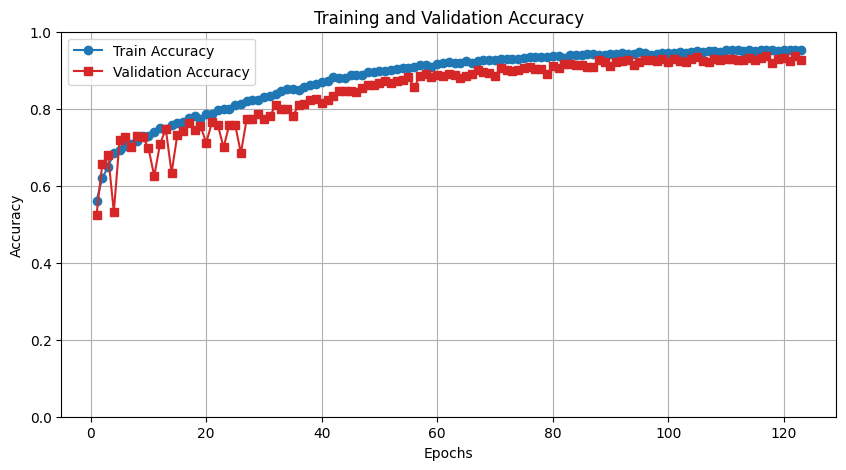

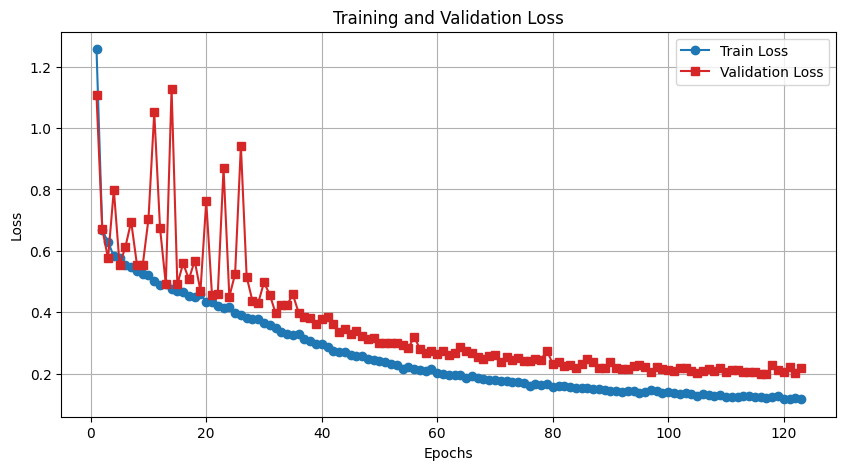

In [12]:
# Plot accuracy and loss curves
plot_train_val_accuracy(train_accuracies, val_accuracies)
plot_train_val_loss(train_loss, val_loss)

## Test data
Run model on the test data and view results

In [13]:
# Run model on test data and keep track of metrics
cnn.load_state_dict(torch.load('/kaggle/working/best_cnn.pth'))
cnn.eval()
correct = 0
total = 0
all_probs = []
all_preds = []
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device).view(-1) 

        output, _ = cnn(X_batch)
        output = output.view(-1)

        probs = torch.sigmoid(output)
        preds = (probs >= 0.5).float()

        all_probs.extend(probs.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(y_batch.cpu().numpy())

        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)

/tmp/ipykernel_19/186817971.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cnn.load_state_dict(torch.load('/kaggle/working/best_cnn.pth'))


In [14]:
# Convert lists to arrays
y_test = np.array(all_labels)
y_pred = np.array(all_preds)
y_prob = np.array(all_probs)

# Save arrays
np.save('/kaggle/working/y_test_tuned.npy', y_test)
np.save('/kaggle/working/y_pred_tuned.npy', y_pred)
np.save('/kaggle/working/y_prob_tuned.npy', y_prob)

In [15]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
confusion_df = pd.DataFrame(cm,
                            index = ['Actually Not Readmitted', 'Actually Readmitted'],
                            columns = ['Predicted Not Readmitted', 'Predicted Readmitted'])
print("Confusion Matrix:")
print(confusion_df)
print("\n" + "-"*80 + "\n")

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

Confusion Matrix:
                         Predicted Not Readmitted  Predicted Readmitted
Actually Not Readmitted                      3247                   154
Actually Readmitted                           340                  3079

--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.95      0.93      3401
         1.0       0.95      0.90      0.93      3419

    accuracy                           0.93      6820
   macro avg       0.93      0.93      0.93      6820
weighted avg       0.93      0.93      0.93      6820



In [16]:
# Compute and print metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Test Accuracy: 0.9276
Precision: 0.9524
Recall: 0.900556
F1-Score: 0.9257
AUC: 0.9755


In [17]:
def plot_roc_curve(fpr, tpr):
    """
    Plot ROC curve
    """
    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, color='tab:blue', label=f"ROC Curve (AUC = {auc:.2f})", linewidth=2)
    plt.plot([0,1], [0,1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid(True, alpha=0.2)
    plt.tight_layout()
    plt.savefig('/kaggle/working/roc.png')
    plt.show()

def pr_and_f1_curves(y_true, y_prob):
    """
    Plot precision-recall curve and F1 vs threshold curve.
    """
    # PR data
    prec, rec, thresh = precision_recall_curve(y_true, y_prob)
    prec, rec = prec[:-1], rec[:-1]
    f1 = 2 * (prec * rec) / (prec + rec + 1e-8)

    best_idx      = np.argmax(f1)
    best_thr      = thresh[best_idx]
    best_f1       = f1[best_idx]
    avg_prec      = average_precision_score(y_true, y_prob)

    fig, ax = plt.subplots(1, 2, figsize=(11, 4.5))

    # Left: PR curve
    ax[0].plot(rec, prec, color='tab:blue', label=f'PR curve  (AP = {avg_prec:.3f})')
    ax[0].scatter(rec[best_idx], prec[best_idx], color='red', zorder=5,
                  label=f'Best F₁ = {best_f1:.3f}\n@ thr = {best_thr:.2f}')
    ax[0].set_xlabel('Recall')
    ax[0].set_ylabel('Precision')
    ax[0].set_title('Precision–Recall curve')
    ax[0].legend()
    ax[0].grid(True)

    # Right: F1 vs threshold
    ax[1].plot(thresh, f1, color='tab:blue')
    ax[1].scatter(best_thr, best_f1, color='red', zorder=5)
    ax[1].set_xlabel('Threshold')
    ax[1].set_ylabel('F₁ score')
    ax[1].set_title('F₁ score vs decision threshold')
    ax[1].grid(True)

    plt.tight_layout()
    plt.savefig('/kaggle/working/pr_f1.png')
    plt.show()

    return best_thr, best_f1

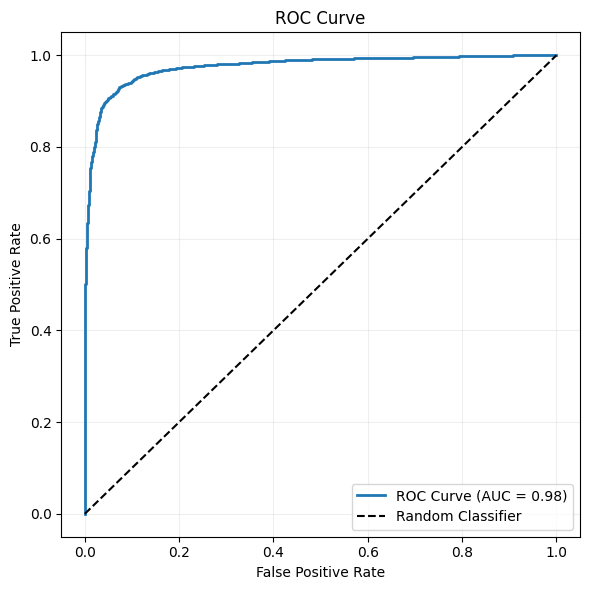

In [18]:
# ROC curve
plot_roc_curve(fpr, tpr)

## Maximizing F1 score
Inspect the precision-recall curve and f1 vs threshold score, and change threshold to maximise F1 score

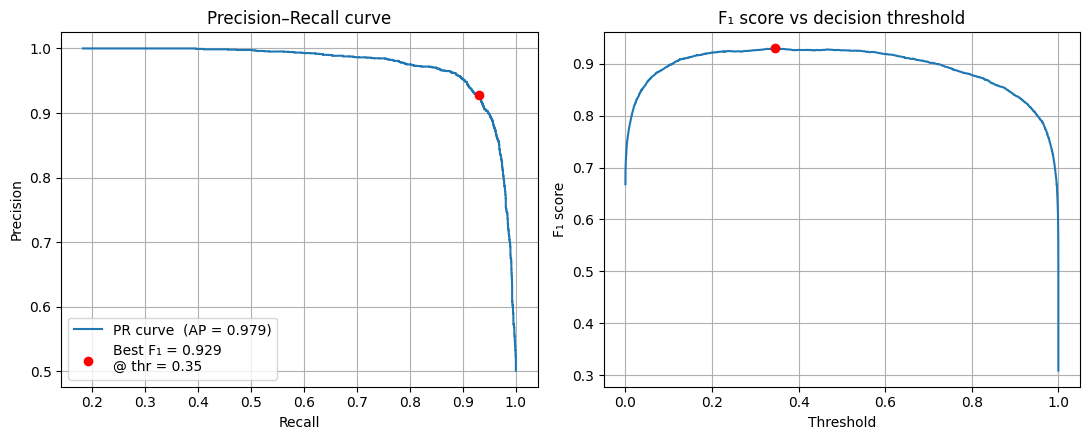

Optimal threshold = 0.346  |  Best F1 = 0.929


In [19]:
# Plot precision-recall and F1 vs threshold plots
best_thr, best_f1 = pr_and_f1_curves(all_labels, all_probs)
print(f"Optimal threshold = {best_thr:.3f}  |  Best F1 = {best_f1:.3f}")

In [20]:
# Change threshold to maximise F1 score
final_preds = (np.array(all_probs) >= best_thr).astype(int)

In [21]:
# New confusion matrix
cm = confusion_matrix(y_test, final_preds)
confusion_df = pd.DataFrame(cm,
                            index = ['Actually Not Readmitted', 'Actually Readmitted'],
                            columns = ['Predicted Not Readmitted', 'Predicted Readmitted'])
print("Confusion Matrix:")
print(confusion_df)
print("\n" + "-"*80 + "\n")

# Classification report
print("Classification Report:")
print(classification_report(y_test, final_preds, zero_division=0))

Confusion Matrix:
                         Predicted Not Readmitted  Predicted Readmitted
Actually Not Readmitted                      3152                   249
Actually Readmitted                           236                  3183

--------------------------------------------------------------------------------

Classification Report:
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93      3401
         1.0       0.93      0.93      0.93      3419

    accuracy                           0.93      6820
   macro avg       0.93      0.93      0.93      6820
weighted avg       0.93      0.93      0.93      6820



In [22]:
# Recompute and print metrics
accuracy = accuracy_score(y_test, final_preds)
precision = precision_score(y_test, final_preds, zero_division=0)
recall = recall_score(y_test, final_preds, zero_division=0)
f1 = f1_score(y_test, final_preds, zero_division=0)
auc = roc_auc_score(y_test, y_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC: {auc:.4f}")

Test Accuracy: 0.9289
Precision: 0.9274
Recall: 0.930974
F1-Score: 0.9292
AUC: 0.9755
